# Testing the Peak Detection Algorithm
## Quantification of the amount of well detected peaks
### CheckList
- Genereate clean synthetic ECG signals
- Calculate the amount of peaks present
- Add noises with different amounts
- Check the peaks detected with he agorithm and compare them to the total of them

In [318]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import signal
import math
import statistics
import neurokit2 as nk
from scipy.signal import butter, filtfilt, iirnotch, savgol_filter
import scipy.signal
import peakutils.peak
import seaborn as sns
import padasip as pa
import random

from misc.noisesynthetic import *
from misc.peakdetection import *

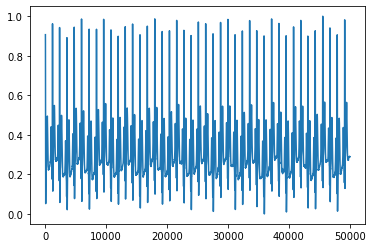

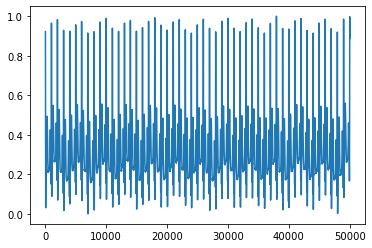

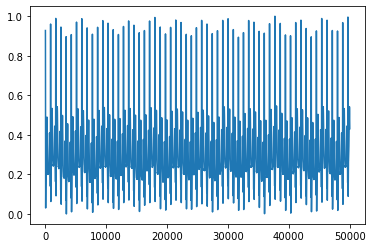

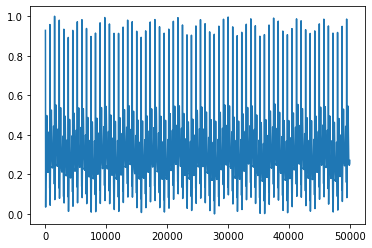

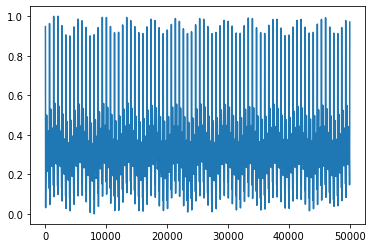

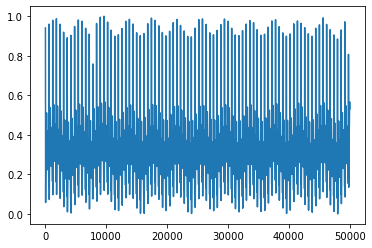

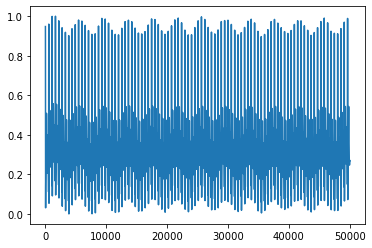

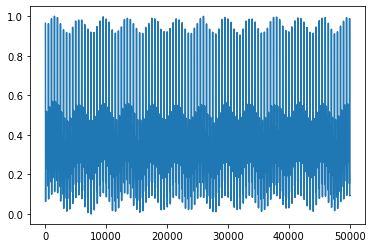

In [319]:
# We generate a dataframe containing different synthetic clean signals with different HRs.
pd_signals = pd.DataFrame()

hrs = np.arange(50,130,10) # array containing the different HRs

for hr in hrs:
    ecg = nk.ecg_simulate(duration=50, sampling_rate=1000, heart_rate=hr)
    normalised = (ecg - np.min(ecg)) / np.max(ecg-np.min(ecg))
    pd_signals['HR'+str(hr)] = ecg
    plt.plot(normalised)
    plt.show()


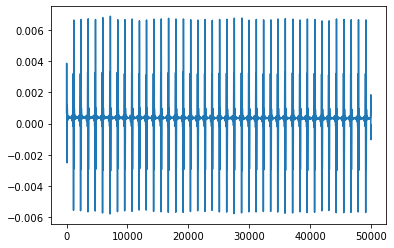

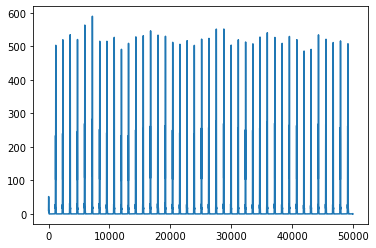

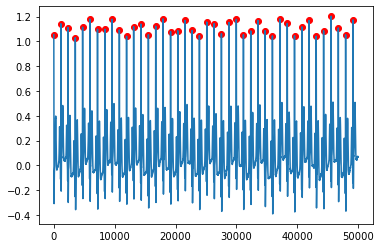

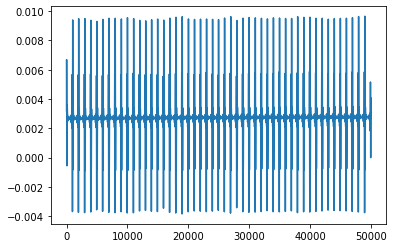

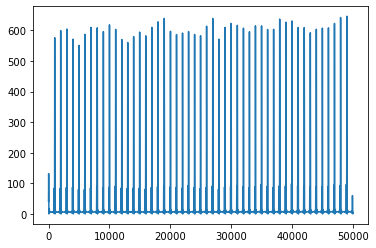

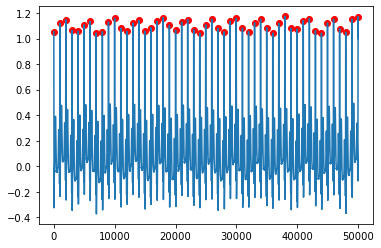

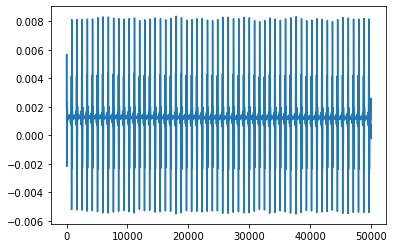

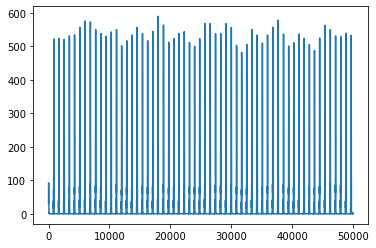

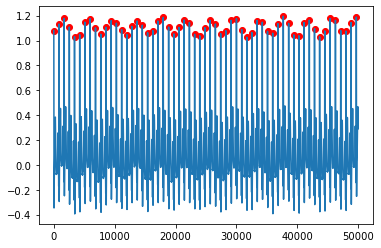

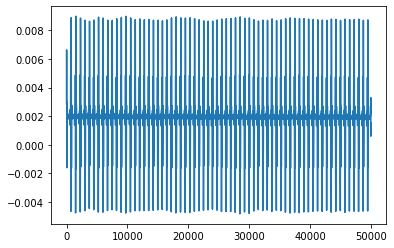

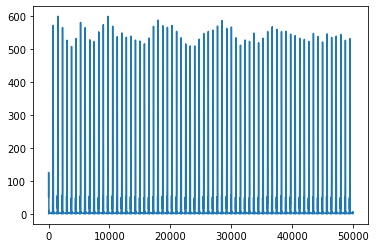

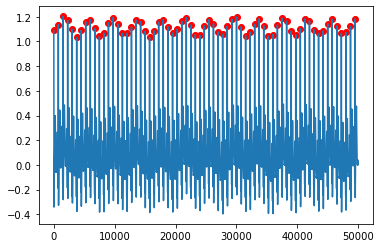

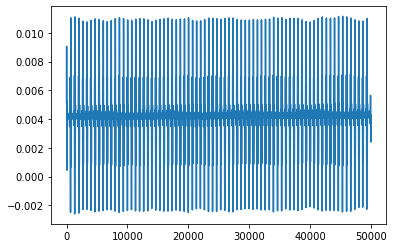

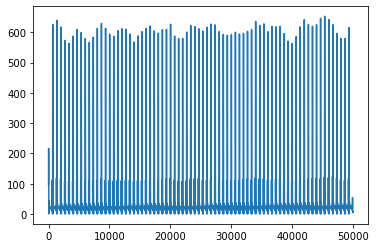

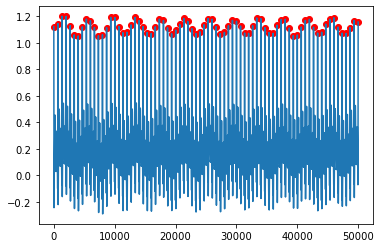

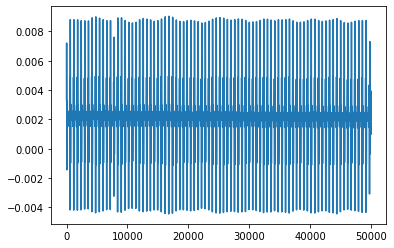

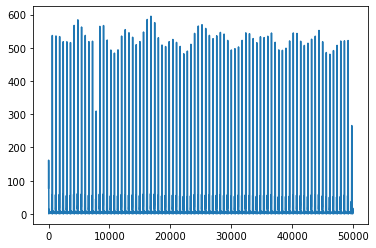

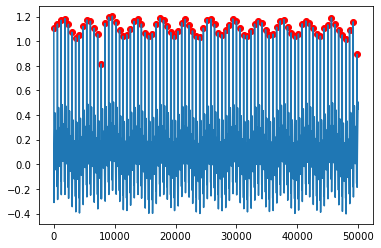

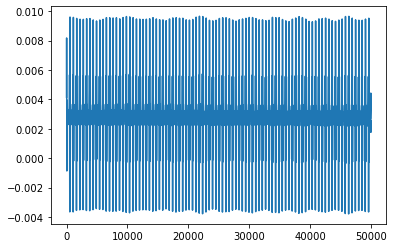

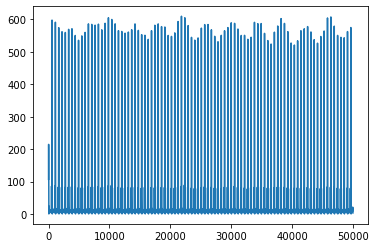

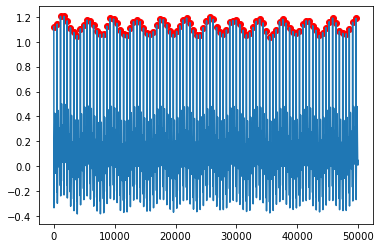

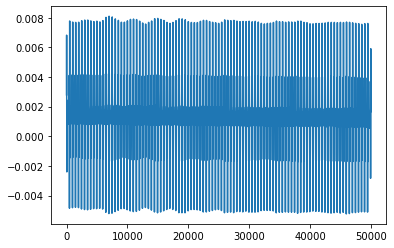

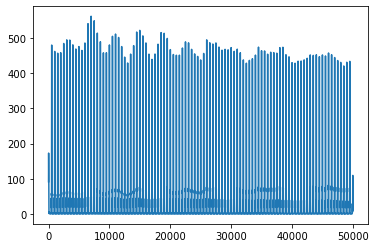

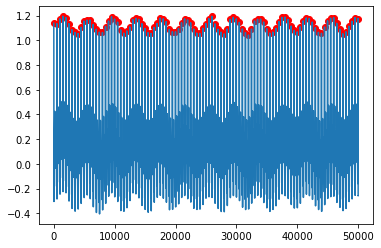

In [334]:
# We find the peaks of the cleaned singnals and store them into a dataframe: a listcheck panda, our true arrays.
true_peaks = {value+':TruePeaks':[] for value in pd_signals}
true_peaks_nk = {value+':TruePeaks':[] for value in pd_signals}
num_peaks = []
num_peaks_nk = []
for column in pd_signals:
    peaks_nk = nk.ecg_findpeaks(pd_signals[column], sampling_rate=1000, method="elgendi2010", show=False)
    peaks = _filteringdet(pd_signals[column],1000)
    
    num_peaks.append(len(peaks['x_values']))
    num_peaks_nk.append(len(peaks_nk['ECG_R_Peaks']))
        
    true_peaks[column+':TruePeaks'] += [value for value in peaks['x_values'].tolist()]
    true_peaks_nk[column+':TruePeaks'] += [value for value in peaks_nk['ECG_R_Peaks'].tolist()]

true_peaks = dict([ (k,pd.Series(v)) for k,v in true_peaks.items() ])
true_peaks_nk = dict([ (k,pd.Series(v)) for k,v in true_peaks.items() ])
pd_true_peaks = pd.DataFrame(true_peaks)
pd_true_peaks_nk = pd.DataFrame(true_peaks_nk)


#### Artifacts
- Power Interference
- Baseline Wonder
- EMG noise
- White noise

In [346]:
# We generate several dataframes adding noise to the signals with different amounts 
pd_noisy_signals = pd.DataFrame()

for column in pd_signals:
    power = powerinterference(pd_signals[column], 1000, amplitude=0.08)
    bw = gen_bw_noise(power, 0.000008, amplitude=1.5)
    emg = emgnoise(bw,std=0.02)
    wn = gen_white_noise(emg,stan=0.02)
    pd_noisy_signals[column] = wn
    

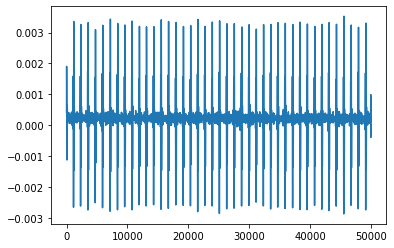

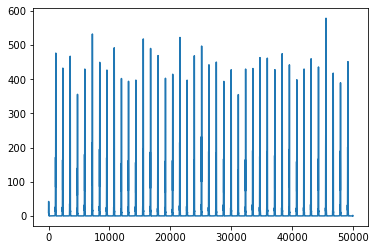

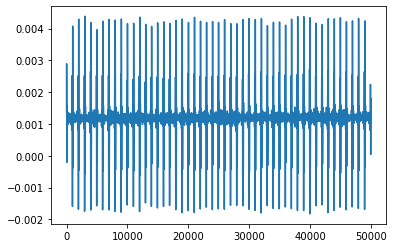

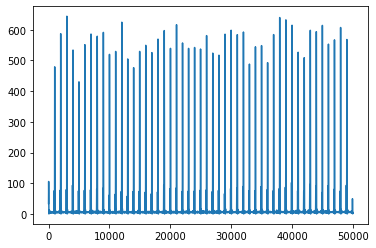

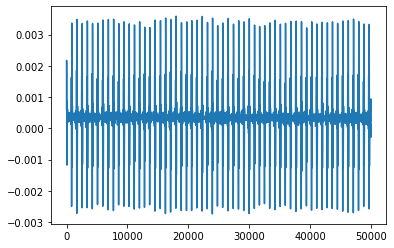

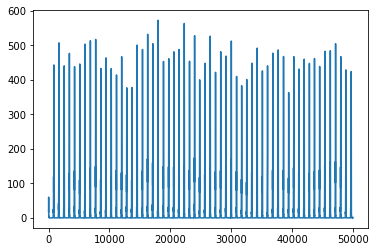

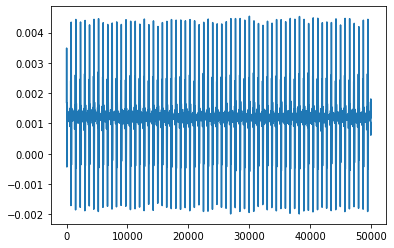

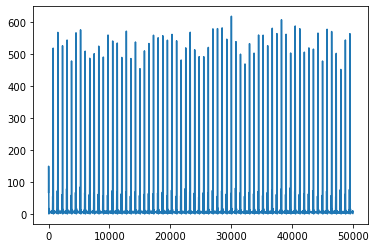

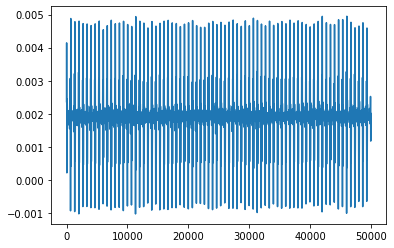

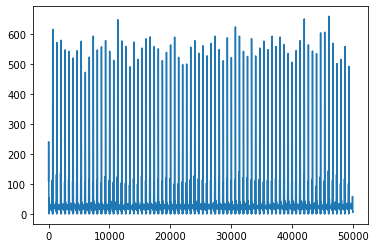

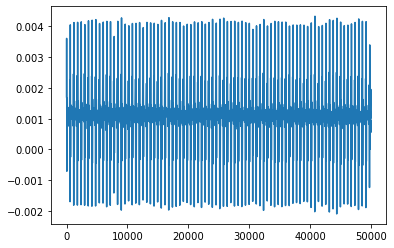

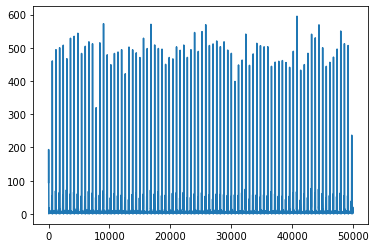

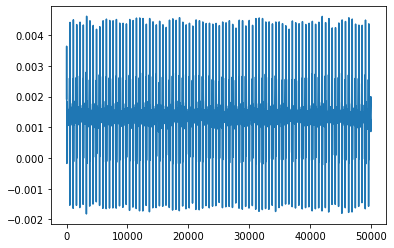

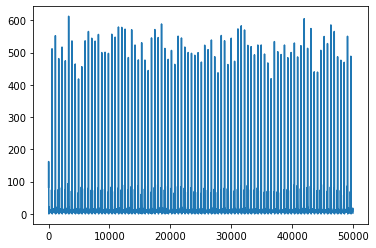

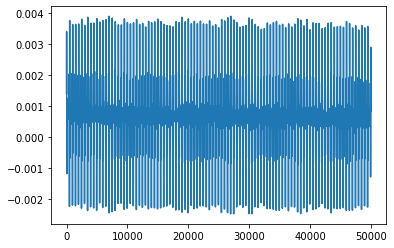

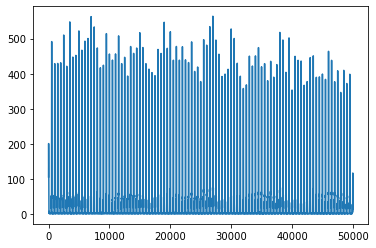

[42, 51, 59, 67, 76, 84, 92, 101]
[42, 38, 59, 67, 74, 84, 92, 101]
[42, 38, 59, 67, 74, 84, 92, 101]


In [347]:
# We detect the peaks using our algorithm and then we compare.
detected_indexes = []
detected_indexes_nk = []

for column in pd_noisy_signals:
    peaks = _filteringdet(pd_noisy_signals[column],1000)
    true_index = []
    true_index_nk = []
    
    for index,value in enumerate(peaks['x_values']):
        if float('-inf') < float(pd_true_peaks[column+':TruePeaks'][index]) < float('inf'):
            if int(pd_true_peaks[column+':TruePeaks'][index])-11 <= value <=int(pd_true_peaks[column+':TruePeaks'][index])+11:
                true_index.append(index)
    detected_indexes.append(len(true_index))
    
    for index,value in enumerate(peaks['x_values']):
        if float('-inf') < float(pd_true_peaks_nk[column+':TruePeaks'][index]) < float('inf'):
            if int(pd_true_peaks_nk[column+':TruePeaks'][index])-11 <= value <=int(pd_true_peaks_nk[column+':TruePeaks'][index])+11:
                true_index_nk.append(index)
    detected_indexes_nk.append(len(true_index_nk))
        
print(num_peaks)
print(detected_indexes)
print(detected_indexes_nk)
    
    